In [23]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import astropy.units as u

from scipy.optimize import minimize
import scipy.stats
# import sklearn.mixture as sm
from scipy.special import logsumexp
import emcee

# import myutils
from pyia import GaiaData
import pickle

In [24]:
plt.style.use('notebook')

In [3]:
R = np.load('../data/jhelum_rotmat_init.npy')

In [4]:
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import matrix_transpose

class Jhelum(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the track of the PS1-A stream

    For more information about this class, see the Astropy documentation
    on coordinate frames in :mod:`~astropy.coordinates`.

    Parameters
    ----------
    representation : :class:`~astropy.coordinates.BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)

    phi1 : angle_like, optional, must be keyword
        The longitude-like angle corresponding to Orphan's orbit.
    phi2 : angle_like, optional, must be keyword
        The latitude-like angle corresponding to Orphan's orbit.
    distance : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    pm_phi1_cosphi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the longitude-like direction corresponding to
        the Orphan stream's orbit.
    pm_phi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the latitude-like direction perpendicular to the
        Orphan stream's orbit.
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    """
    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'phi1'),
            coord.RepresentationMapping('lat', 'phi2'),
            coord.RepresentationMapping('distance', 'distance')],
        coord.SphericalCosLatDifferential: [
            coord.RepresentationMapping('d_lon_coslat', 'pm_phi1_cosphi2'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')],
        coord.SphericalDifferential: [
            coord.RepresentationMapping('d_lon', 'pm_phi1'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }

    frame_specific_representation_info[coord.UnitSphericalRepresentation] = \
        frame_specific_representation_info[coord.SphericalRepresentation]
    frame_specific_representation_info[coord.UnitSphericalCosLatDifferential] = \
        frame_specific_representation_info[coord.SphericalCosLatDifferential]
    frame_specific_representation_info[coord.UnitSphericalDifferential] = \
        frame_specific_representation_info[coord.SphericalDifferential]


@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.ICRS, Jhelum)
def icrs_to_jhelum():
    """ Compute the transformation from Galactic spherical to
        heliocentric Jhelum coordinates.
    """
    return R

@frame_transform_graph.transform(coord.StaticMatrixTransform, Jhelum, coord.ICRS)
def jhelum_to_icrs():
    """ Compute the transformation from heliocentric Jhelum coordinates to
        spherical Galactic.
    """
    return matrix_transpose(icrs_to_jhelum())

In [5]:
t = Table(fits.getdata('../data/jhelum_des.fits'))

In [6]:
g = GaiaData(t)
c = coord.SkyCoord(ra=g.ra, dec=g.dec,
                   pm_ra_cosdec=g.pmra, pm_dec=g.pmdec)

In [7]:
iso = Table.read('../data/mist_12.0_-1.50.cmd', format='ascii.commented_header', header_start=12)
phasecut = (iso['phase']>=0) & (iso['phase']<4)
iso = iso[phasecut]

In [8]:
# distance modulus
distance_app = 12.8*u.kpc
dm = 5*np.log10((distance_app.to(u.pc)).value)-5

# main sequence + rgb
i_gi = iso['DECam_g']-iso['DECam_i'] + 0.05
i_g = iso['DECam_g']+dm

i_left = i_gi - 0.4*(i_g/28)**5
i_right = i_gi + 0.55*(i_g/28)**5

poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
ind = (poly[:,1]<21.3) & (poly[:,1]>19)
poly_main = poly[ind]

In [9]:
wangle = 180*u.deg

In [10]:
def jhelum_dist(phi1, d0=12.8, d1=0, d2=0):
    p1, p2 = 0, 20
    if (d1==0) | (d2==0):
        d1, d2 = d0, d0
    m = (d2-d1) / (p2-p1)
    return (m*(phi1.wrap_at(wangle).value - p1) + d1) * u.kpc

In [11]:
# adopt 13kpc
d0 = 13
d1 = 0
d2 = 0

cj = c.transform_to(Jhelum)
cj_dist = Jhelum(phi1=cj.phi1, phi2=cj.phi2,
                    distance=jhelum_dist(cj.phi1, d0=d0, d1=d1, d2=d2),
                    pm_phi1_cosphi2=cj.pm_phi1_cosphi2,
                    pm_phi2=cj.pm_phi2,
                    radial_velocity=[0]*len(cj)*u.km/u.s)

# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = cj_dist.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
cj = coord.Galactic(rep).transform_to(Jhelum)

In [12]:
# masks
phi2_mask = (cj.phi2<1*u.deg) & (cj.phi2>0*u.deg) & (cj.phi1>0*u.deg) & (cj.phi1<25*u.deg)
phi2off_mask = (((cj.phi2<-3.5*u.deg) & (cj.phi2>-4*u.deg)) | ((cj.phi2<4*u.deg) & (cj.phi2>3.5*u.deg)) &
                (cj.phi1>0*u.deg) & (cj.phi1<25*u.deg))

points = np.array([g.g0 - g.i0, g.g0]).T
path_main = mpl.path.Path(poly_main)
cmd_mask = path_main.contains_points(points)

pm1_min = -8*u.mas/u.yr
pm1_max = -4*u.mas/u.yr
pm2_min = -2*u.mas/u.yr
pm2_max = 2.*u.mas/u.yr
pm_mask = ((cj.pm_phi1_cosphi2 < pm1_max) & (cj.pm_phi1_cosphi2 > pm1_min) & 
           (cj.pm_phi2 < pm2_max) & (cj.pm_phi2 > pm2_min))

bhb_gi_min = -0.7
bhb_gi_max = -0.2
bhb_g_min = 15.5
bhb_g_max = 16.5
bhb_mask = (g.g0-g.i0<bhb_gi_max) & (g.g0-g.i0>bhb_gi_min) & (g.g0<bhb_g_max) & (g.g0>bhb_g_min)

poly_bs = np.array([[0.2,18.9], [0.2, 19.9], [-0.25, 18.7], [-0.25,17.7]])
path_bs = mpl.path.Path(poly_bs)
bs_mask = path_bs.contains_points(points)

/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


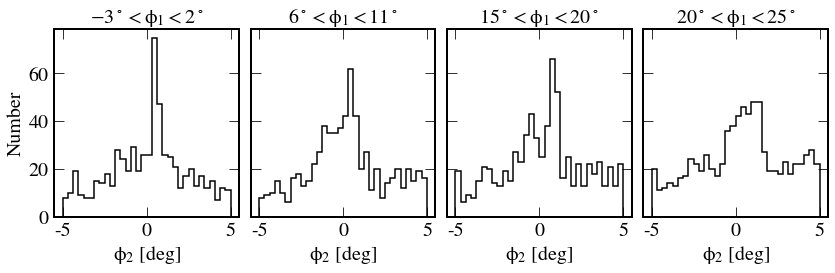

In [13]:
phi1_ranges0 = np.array([-3,6,15,20])*u.deg
phi1_ranges1 = np.array([2,11,20,25])*u.deg
by_fine = np.linspace(-5,5,40)
by_fine = np.linspace(-5,5,33)

fig, ax = plt.subplots(1,4,figsize=(12,4.2), sharey=True, sharex=True)
for e in range(4):
    plt.sca(ax[e])
    
    ind = ((cj.phi1[pm_mask & cmd_mask].wrap_at(wangle)>phi1_ranges0[e]) & 
    (cj.phi1[pm_mask & cmd_mask].wrap_at(wangle)<phi1_ranges1[e]))
    
#     plt.hist(cj.phi2[pm_mask & cmd_mask & phi1_mask], bins=by_fine, histtype='stepfilled', color='k', alpha=0.3,
#              lw=1.5, normed=True)
    plt.hist(cj.phi2[pm_mask & cmd_mask][ind], bins=by_fine, histtype='step', color='k', lw=1.5,
            normed=False)
    
    if e==0:
        plt.ylabel('Number')
    plt.xlabel('$\phi_2$ [deg]')
    plt.title('${:.0f}^\circ<\phi_1<{:.0f}^\circ$'.format(phi1_ranges0[e].value, phi1_ranges1[e].value),
             fontsize='medium')

plt.tight_layout(w_pad=0.5)
# plt.savefig('../paper/phi2_histograms.pdf')

In [14]:
bsize = 5*u.deg
bspace = 2*u.deg
be_left = np.arange(-5,23,bspace.value)*u.deg 
be_right = be_left + bsize
Nbin = np.size(be_left)

In [15]:
Nbin

14

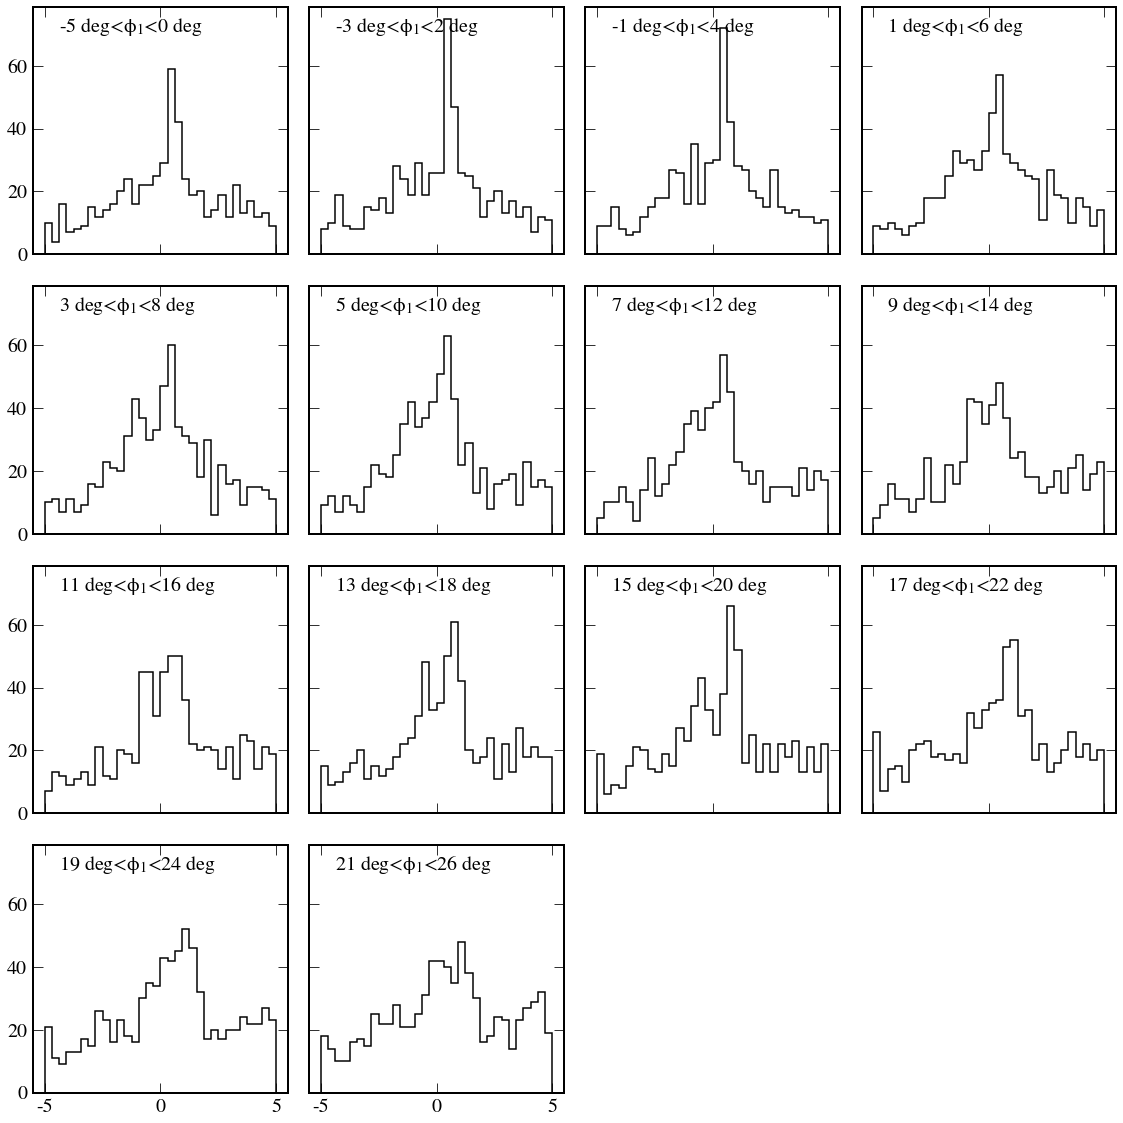

In [16]:
da = 4
nrow = 4
ncol = 4
fig, ax = plt.subplots(nrow,ncol,figsize=(ncol*da,nrow*da), sharex=True, sharey=True)

indices = []

for i in range(nrow):
    for j in range(ncol):
        plt.sca(ax[i][j])
        e = i*ncol + j
        if e<Nbin:
            ind = ((cj.phi1[pm_mask & cmd_mask].wrap_at(wangle)>be_left[e]) & 
                   (cj.phi1[pm_mask & cmd_mask].wrap_at(wangle)<be_right[e]))
            indices += [ind]
            
            plt.hist(cj.phi2[pm_mask & cmd_mask][ind], bins=by_fine, histtype='step', color='k', lw=1.5,
                normed=False)

            plt.text(0.1,0.9,'{:.0f}<$\phi_1$<{:.0f}'.format(be_left[e], be_right[e]),
                    transform=plt.gca().transAxes)
        else:
            plt.axis('off')

plt.tight_layout()

In [67]:
def lnnormal(x, mu, std):
    return -0.5 * (x-mu)**2 / std**2 - 0.5*np.log(2*np.pi) - np.log(std)

def lnprior(p):
    a1, a2, mu1, mu2, lnstd1, lnstd2, lnabg = p
    
    lp = 0
    
    fs = [a1, a2]
    for f in fs:
        if f < 0 or f > 1:
            return -np.inf
    
    if mu1 < mu2:
       return -np.inf
    
    if sum(fs) > 1:
        return -np.inf
    
    if mu1 < -4 or mu1 > 4 or mu2 < -4 or mu2 > 4:
        return -np.inf
    
    if (lnabg > 0) | (lnabg<-1e3):
        return -np.inf
    
    lp += lnnormal(lnstd1, -1, 5)
    lp += lnnormal(lnstd2, -1, 5)
    
    return lp

def lnlike(p, phi2):
    a1, a2, mu1, mu2, lnstd1, lnstd2, lnabg = p
    a_bg = 1 - a1 - a2
    
    component1 = lnnormal(phi2, mu1, np.exp(lnstd1))
    component2 = lnnormal(phi2, mu2, np.exp(lnstd2))
#     bg = np.full_like(component1, -np.log(5 - -5))
    bg = np.log(np.exp(lnabg) * phi2 + 1/(5 - -5)) # to normalize over phi_2 = -5 to 5
    
    return logsumexp([component1, component2, bg], b=np.array([a1, a2, a_bg])[:, None], axis=0)

def lnprob(p, phi2):
    lp = lnprior(p)
    if not np.all(np.isfinite(lp)):
        return -np.inf
    
    ll = lnlike(p, phi2)
    if not np.all(np.isfinite(ll)):
        return -np.inf
    
    return ll.sum() + lp

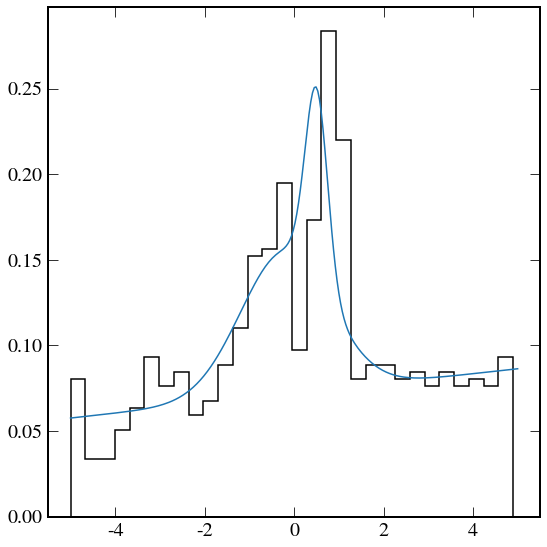

In [68]:
phi1_mask = (cj.phi1.wrap_at(wangle)>-5*u.deg) & (cj.phi1.wrap_at(wangle)<25*u.deg)
bins = np.arange(-5, 5+1e-3, 0.33)

p0s = [0.07, 0.21, # a1, a2
       0.5, -0.2, # mu1, mu2, 
       np.log(0.25), np.log(1), np.log(4e-3)] #lnstd_s1, lnstd_s2,
    
phi2_grid = np.linspace(-5, 5, 256)

plt.hist(cj.phi2[pm_mask & cmd_mask][indices[10]].to(u.deg).value, 
         bins=bins, histtype='step', lw=1.5, normed=True, color='k')

plt.plot(phi2_grid, np.exp(lnlike(p0s, phi2_grid)))

plt.tight_layout()

In [69]:
nwalkers = 64
nsteps = 4096
nsteps = 2048

p0 = emcee.utils.sample_ball(p0s, [1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3], nwalkers)
p0[:,:2] = np.abs(p0[:,:2])
p0[:,-1] = -np.abs(p0[:,-1])

sampler = emcee.EnsembleSampler(nwalkers, p0.shape[1], threads=2,
                                lnpostfn=lnprob, args=(cj.phi2[pm_mask & cmd_mask][indices[10]].to(u.deg).value, ))
_ = sampler.run_mcmc(p0, nsteps)


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log


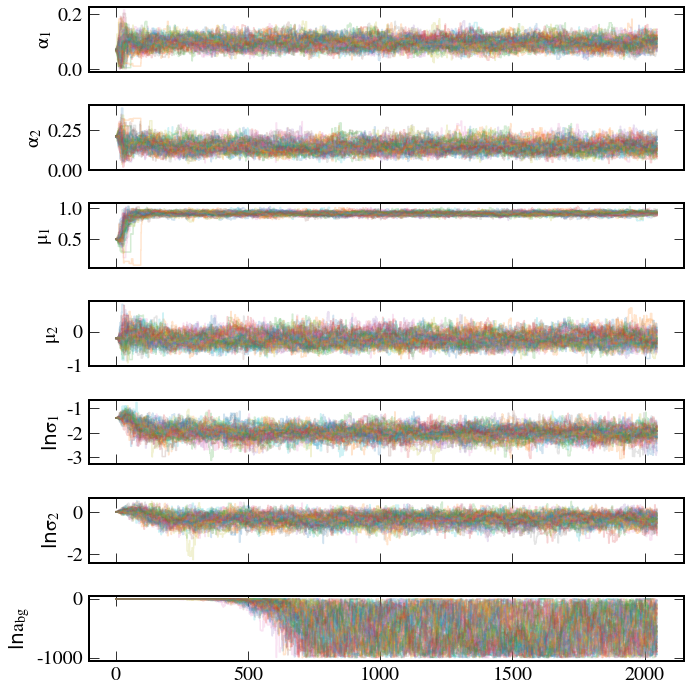

In [70]:
names = [r'$\alpha_{1}$', r'$\alpha_{2}$',  
         r'$\mu_1$', r'$\mu_2$',
         r'$\ln\sigma_{1}$', r'$\ln\sigma_{2}$', r'$\ln a_{bg}$']

fig, axes = plt.subplots(sampler.dim,
                         figsize=(10,10), 
                         sharex=True)
    
for k in range(sampler.dim):
    for walker in sampler.chain[..., k]:
        axes[k].plot(walker, marker='', drawstyle='steps-mid', alpha=0.2)

for i in range(len(names)):
    axes[i].set_ylabel(names[i])
            
fig.tight_layout()

In [71]:
idx = sampler.lnprobability[:, -1].argmax()
show_p = sampler.chain[idx, -1]
print(show_p[:4], np.exp(show_p[4:]))

[ 0.09552488  0.14198785  0.92744191 -0.19882631] [0.11725248 0.65604645 0.        ]


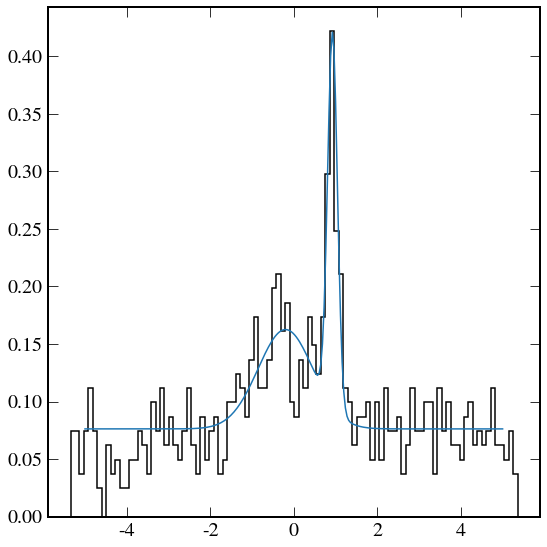

In [72]:
plt.hist(cj.phi2[pm_mask & cmd_mask][indices[10]].to(u.deg).value, 
         bins=100, histtype='step', lw=1.5, density=True, color='k')

plt.plot(phi2_grid, np.exp(lnlike(show_p, phi2_grid)))

plt.tight_layout()

## Fit individual bins in phi1

In [26]:
def sample_phi2(phi2, threads=2, seed=54987, nwalkers=64, nsteps=2048):
    """Return an emcee sampler after sampling 2 normal components in the distribution of phi2"""
    np.random.seed(seed)
    
    p0 = emcee.utils.sample_ball(p0s, [1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3], nwalkers)
    p0[:,:2] = np.abs(p0[:,:2])
    p0[:,-1] = -np.abs(p0[:,-1])
    
    sampler = emcee.EnsembleSampler(nwalkers, p0.shape[1], threads=threads, lnpostfn=lnprob, args=(phi2,))
    _ = sampler.run_mcmc(p0, nsteps)

    return sampler

In [73]:
torun = True
if torun:
    for i in range(Nbin):
        phi2 = cj.phi2[pm_mask & cmd_mask][indices[i]].to(u.deg).value
        sampler = sample_phi2(phi2, threads=2, seed=542987, nwalkers=64, nsteps=2048)
        out_dict = {'lnprobability': sampler.lnprobability, 'chain': sampler.chain, 'dim': sampler.dim}
        pickle.dump(out_dict, open('../data/chains/profile_2component_{:02d}.pkl'.format(i), 'wb'))

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log
/usr/lib/python3.6/site-pack

### Convergence diagnostics

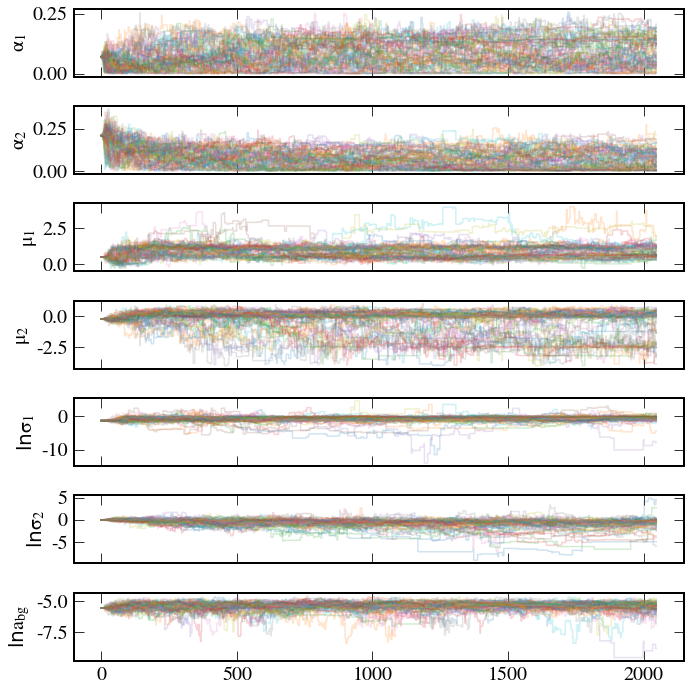

In [74]:
names = [r'$\alpha_{1}$', r'$\alpha_{2}$',  
         r'$\mu_1$', r'$\mu_2$',
         r'$\ln\sigma_{1}$', r'$\ln\sigma_{2}$', r'$\ln a_{bg}$']

for i in range(Nbin):
    sampler = pickle.load(open('../data/chains/profile_2component_{:02d}.pkl'.format(i), 'rb'))
    plt.close()
    fig, axes = plt.subplots(sampler['dim'], figsize=(10,10), sharex=True)

    for k in range(sampler['dim']):
        for walker in sampler['chain'][..., k]:
            axes[k].plot(walker, marker='', drawstyle='steps-mid', alpha=0.2)

    for j in range(len(names)):
        axes[j].set_ylabel(names[j])

    fig.tight_layout()
    plt.savefig('../plots/diag_chain_2component_{:02d}.png'.format(i))

### Extract best-fit parameters

In [94]:
best_param = np.empty((Nbin, np.size(p0s)))
med = np.empty((Nbin, np.size(p0s)))
uerr = np.empty((Nbin, np.size(p0s)))
lerr = np.empty((Nbin, np.size(p0s)))
nstar = np.empty(Nbin)

for i in range(Nbin):
    sampler = pickle.load(open('../data/chains/profile_2component_{:02d}.pkl'.format(i), 'rb'))
    idx = sampler['lnprobability'][:, -1].argmax()
    best_p = sampler['chain'][idx, -1]
    best_param[i] = best_p
    print(best_p[:4], np.exp(best_p[4:]))
#     print(best_p)
    
    sampler['chain'][:,:,4:] = np.exp(sampler['chain'][:,:,4:])
    med[i] = np.median(sampler['chain'][:,1024:,:].reshape(-1,sampler['dim']), axis=0)
    uerr[i] = np.percentile(sampler['chain'][:,1024:,:].reshape(-1,sampler['dim']), 84, axis=0) - med[i]
    lerr[i] = med[i] - np.percentile(sampler['chain'][:,1024:,:].reshape(-1,sampler['dim']), 16, axis=0)
    nstar[i] = np.sum(indices[i])

[0.08728964 0.26530399 0.5741841  0.10648166] [1.39860367e-001 1.33920279e+000 9.88130081e-302]
[0.11227713 0.24585245 0.54680012 0.21502847] [1.31092906e-001 1.42133279e+000 5.31184790e-109]
[0.08894702 0.27610504 0.51483891 0.1511384 ] [0.14318415 1.44034789 0.        ]
[ 0.05757638  0.31122128  0.36337598 -0.02222866] [0.11093001 1.3113801  0.00504403]
[ 0.03649645  0.33578304  0.33264579 -0.04000261] [7.79021277e-002 1.18809128e+000 4.08531700e-154]
[ 0.07688793  0.26343751  0.43774969 -0.40535113] [0.20860383 0.96080019 0.00419086]
[ 0.12787375  0.17445154  0.56467593 -0.68305485] [0.26174086 0.64604062 0.00461114]
[ 0.14096367  0.0824843   0.48969653 -0.6197831 ] [0.3926463  0.28744936 0.00568515]
[ 0.17710214  0.10589249  0.61170452 -0.58983088] [0.41110978 0.28368468 0.00379949]
[0.06103079 0.18585515 0.87586857 0.04030249] [6.56811110e-002 7.79997983e-001 2.85335640e-165]
[ 0.11126586  0.14559086  0.9294096  -0.35459589] [1.40243111e-001 6.27083817e-001 2.20251296e-181]
[0.036

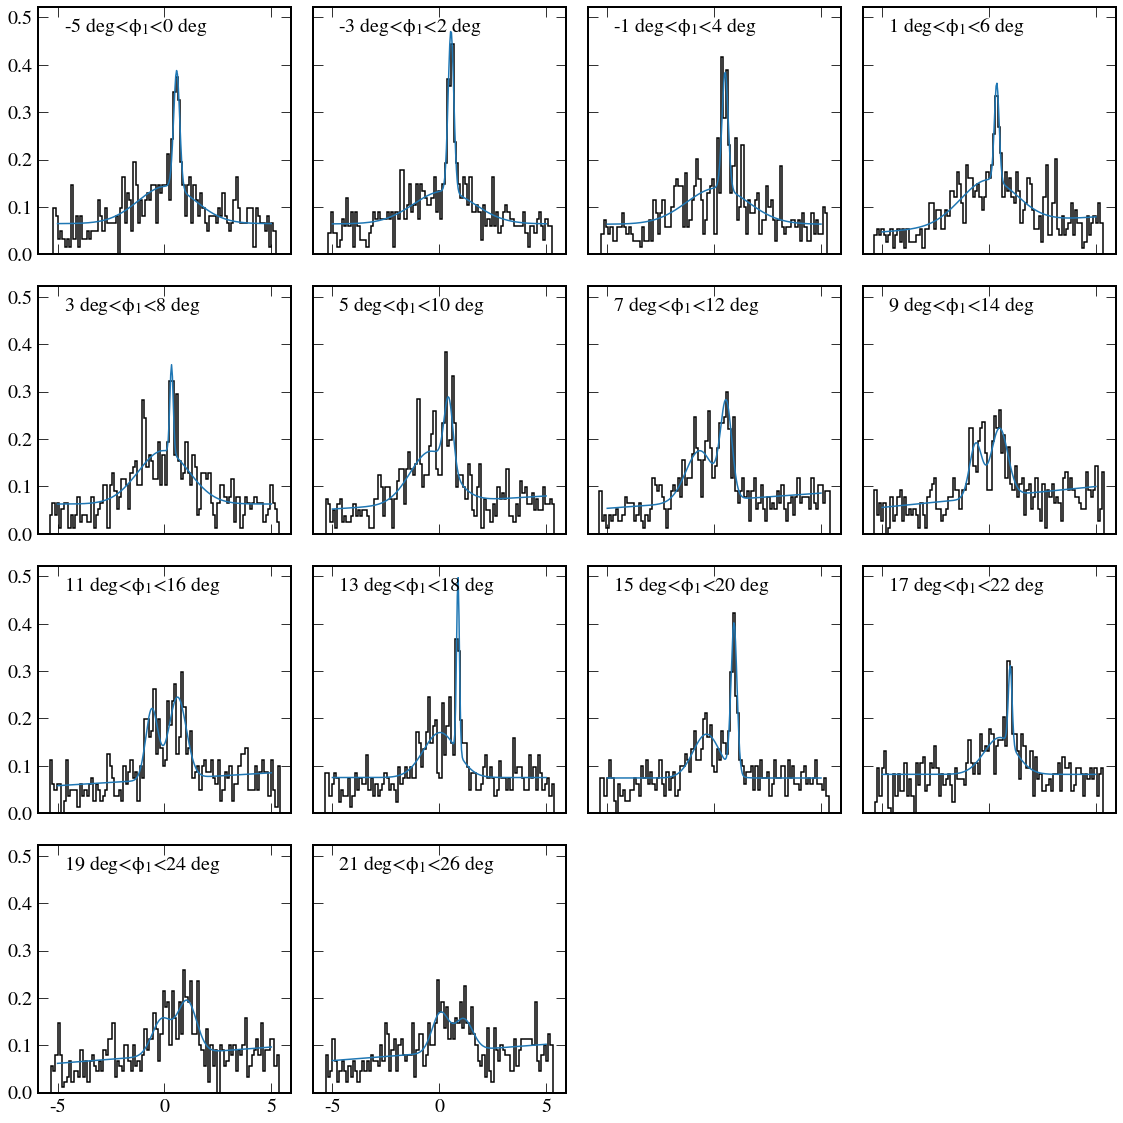

In [88]:
da = 4
nrow = 4
ncol = 4
fig, ax = plt.subplots(nrow,ncol,figsize=(ncol*da,nrow*da), sharex=True, sharey=True)

indices = []

for i in range(nrow):
    for j in range(ncol):
        plt.sca(ax[i][j])
        e = i*ncol + j
        if e<Nbin:
            ind = ((cj.phi1[pm_mask & cmd_mask].wrap_at(wangle)>be_left[e]) & 
                   (cj.phi1[pm_mask & cmd_mask].wrap_at(wangle)<be_right[e]))
            indices += [ind]
            
            plt.hist(cj.phi2[pm_mask & cmd_mask][ind].value, bins=100, histtype='step', color='k', lw=1.5,
                density=True)
            plt.plot(phi2_grid, np.exp(lnlike(best_param[e], phi2_grid)))

            plt.text(0.1,0.9,'{:.0f}<$\phi_1$<{:.0f}'.format(be_left[e], be_right[e]),
                    transform=plt.gca().transAxes)
        else:
            plt.axis('off')

plt.tight_layout()

In [89]:
phi1_cen = 0.5 * (be_left + be_right)

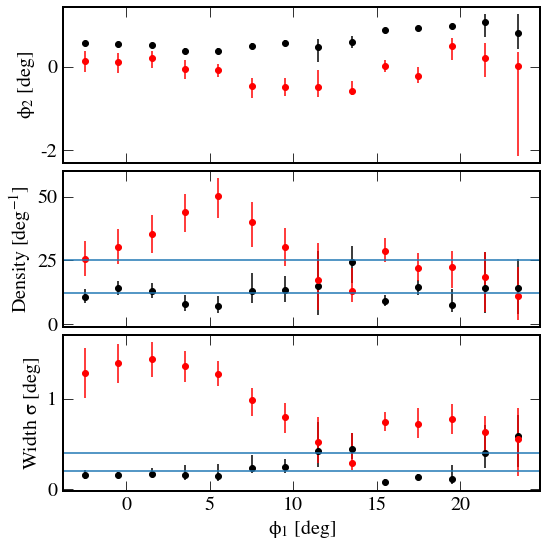

In [116]:
fig, ax = plt.subplots(3,1,figsize=(8,8), sharex=True)

plt.sca(ax[0])
plt.plot(phi1_cen, med[:,2], 'ko')
plt.errorbar(phi1_cen.value, med[:,2], yerr=(lerr[:,2], uerr[:,2]), color='k', fmt='none')
plt.plot(phi1_cen, med[:,3], 'ro')
plt.errorbar(phi1_cen.value, med[:,3], yerr=(lerr[:,3], uerr[:,3]), color='r', fmt='none')
plt.ylabel('$\phi_2$ [deg]')

plt.sca(ax[1])
plt.plot(phi1_cen, med[:,0]*nstar/bsize, 'ko')
plt.errorbar(phi1_cen.value, med[:,0]*nstar/bsize.value, yerr=(lerr[:,0], uerr[:,0])*nstar/bsize.value,
             color='k', fmt='none')
plt.plot(phi1_cen, med[:,1]*nstar/bsize, 'ro')
plt.errorbar(phi1_cen.value, med[:,1]*nstar/bsize.value, yerr=(lerr[:,1], uerr[:,1])*nstar/bsize.value,
             color='r', fmt='none')
plt.axhline(12)
plt.axhline(25)
plt.ylabel('Density [$deg^{-1}$]')

plt.sca(ax[2])
plt.plot(phi1_cen, med[:,4], 'ko')
plt.errorbar(phi1_cen.value, med[:,4], yerr=(lerr[:,4], uerr[:,4]), color='k', fmt='none')
plt.plot(phi1_cen, med[:,5], 'ro')
plt.errorbar(phi1_cen.value, med[:,5], yerr=(lerr[:,5], uerr[:,5]), color='r', fmt='none')
plt.ylabel('Width $\sigma$ [deg]')
plt.axhline(0.2)
plt.axhline(0.4)

plt.xlabel('$\phi_1$ [deg]')
plt.tight_layout(h_pad=0)
plt.savefig('../paper/2component_profile.pdf')

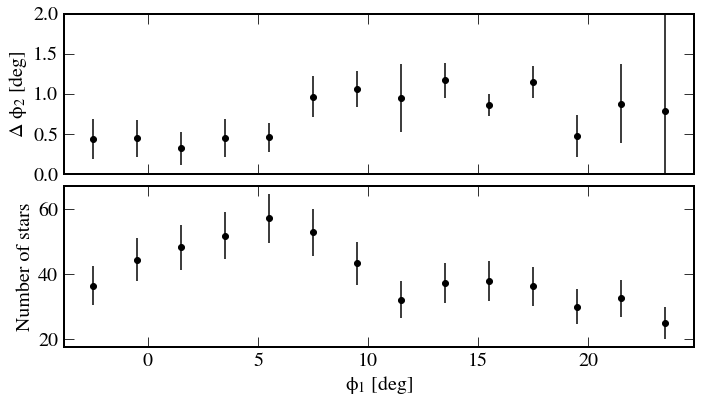

In [117]:
fig, ax = plt.subplots(2,1,figsize=(10,6), sharex=True)

plt.sca(ax[0])
plt.errorbar(phi1_cen.value, med[:,2] - med[:,3],
             yerr=np.sqrt((0.5*(lerr[:,2] + uerr[:,2]))**2 + (0.5*(lerr[:,3] + uerr[:,3]))**2),
             fmt='o', color='k')

plt.ylim(0,2)
plt.ylabel('$\Delta$ $\phi_2$ [deg]')

plt.sca(ax[1])
plt.errorbar(phi1_cen.value, (med[:,0] + med[:,1])*nstar/bsize.value,
             yerr=np.sqrt((med[:,0] + med[:,1])*nstar/bsize.value),
             fmt='o', color='k')

plt.ylabel('Number of stars')
plt.xlabel('$\phi_1$ [deg]')

plt.tight_layout(h_pad=0.1)